In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 47.8 MB/s eta 0:00:00


# **1st try - Simple**
- With only the initial question mark, not yet an image.

In [ ]:
#1. Setup

import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import itertools as it

In [ ]:
#2. Input Image

image = np.array([
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 1, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0],
])

In [ ]:
#Helper: Position Mapping
#Convert (row, column) to position qubits, and identify which should be flipped

def control_positions(row: int, col: int):
    row_binary = f"{row:03b}"
    col_binary = f"{col:03b}"
    qubit_string = row_binary + col_binary
    return [
        pos
        for pos, x
        in enumerate(reversed(qubit_string))
        if x=='0'
    ]

In [ ]:
#3. Circuit Construction

num_pos_qubits = 6  #6 qubits for position (row and column, 3 qubits each)
num_color_qubits = 1  #1 qubit for color (grayscale)
num_wires = num_pos_qubits + num_color_qubits
num_shots=10000
dev = qml.device('default.qubit', wires=num_wires, shots=num_shots)

In [ ]:
#FRQI QNode
#Combining all PennyLane operations

@qml.qnode(dev)
def frqi(image):
    for wire in range(num_pos_qubits):
        qml.Hadamard(wires=wire)

    for (i, j), x in np.ndenumerate(image):
        control_indices = control_positions(i, j)

        qml.Barrier(wires=range(num_wires))
        for idx in control_indices:
            qml.PauliX(wires=idx)
        qml.ctrl(qml.RY, control=list(range(num_pos_qubits)))(x * np.pi, wires=num_pos_qubits)
        for idx in control_indices:
            qml.PauliX(wires=idx)
    return qml.counts(wires=range(num_wires))

(<Figure size 25800x800 with 1 Axes>, <Axes: >)

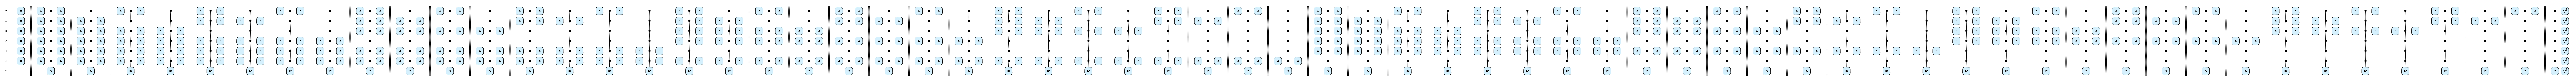

In [ ]:
qml.drawer.use_style('pennylane_sketch')
qml.draw_mpl(frqi)(image)

In [ ]:
#4. Simulation and Reconstruction
#Run the circuit and reconstruct the measured image
#Measure only position (first 6 qubits)

result = frqi(image)
reconstruction = np.zeros((8, 8))

for i, j in it.product(range(8), repeat=2):
    ibin = f"{i:03b}"
    jbin = f"{j:03b}"
    posbits = ibin + jbin

    fullbits = '1' + posbits
    key = fullbits[::-1]

    x = result.get(key, 0)
    reconstruction[i, j] = x / num_shots

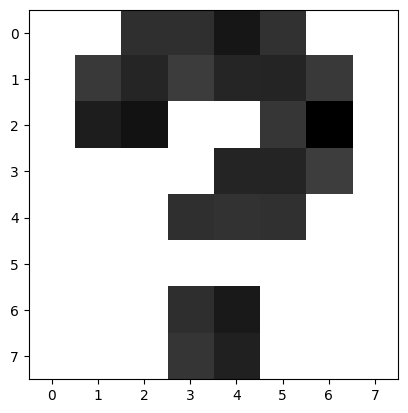

In [ ]:
#5. Plot the result
fig, ax = plt.subplots()
ax.imshow(reconstruction, cmap=plt.cm.binary)
plt.show()